PREDICTIVE ANALYTICS FOR CROP YIELD PREDICTION IN KENYA USING AUTOMATED MACHINE LEARNING

In [2]:
# ===============================
# INSTALL + IMPORTS
# ===============================
!pip install -q pandas numpy openpyxl
import pandas as pd
import numpy as np
import re

# ===============================
# FILE PATHS (change if needed)
# ===============================
MAIZE_PATH = "/content/Maize Production Amounts.xlsx"
TEMP_PATH  = "/content/Surface Air Temperature.xlsx"
RAIN_PATH  = "/content/Precipitation Amounts.xlsx"
SOIL_PATH  = "/content/Soils Data.xlsx"

# ===============================
# HELPERS
# ===============================
def is_year_like(s):
    """Return True if s looks like a year (e.g., '2012' or 2012)."""
    try:
        s_str = str(s).strip()
        return bool(re.fullmatch(r"19\d{2}|20\d{2}", s_str))
    except Exception:
        return False

def canonical_metric(name):
    """Map a messy metric name to a canonical one: Production, Yield, Area."""
    if pd.isna(name):
        return None
    n = str(name).lower()
    if "production" in n or "prod" == n.strip():
        return "Production"
    if "yield" in n:
        return "Yield"
    if "area" in n or "harvest" in n:
        return "Area"
    # fallback: try match common abbreviations
    if "mt" in n and "ha" not in n and "yield" not in n:
        # ambiguous — prefer Production
        return "Production"
    return None

# ===============================
# 1) LOAD MAIZE (attempt MultiIndex header, fallback to simple header)
# ===============================
try:
    maize_df_raw = pd.read_excel(MAIZE_PATH, header=[0,1])
    cols = maize_df_raw.columns
    is_multi = isinstance(cols, pd.MultiIndex)
except Exception:
    maize_df_raw = pd.read_excel(MAIZE_PATH, header=0)
    is_multi = False

# If single header, just load normally
if not is_multi:
    maize_df = maize_df_raw.copy()
    # Ensure the first column is County
    maize_df.rename(columns={maize_df.columns[0]: "County"}, inplace=True)
    maize_df["County"] = maize_df["County"].astype(str).str.strip()
    # If this is already in long form (Year, Indicator, Value), try to detect and convert later
else:
    # MultiIndex: need to create Year_Metric columns
    # Ensure first column is County (could be columns[0] with empty second level)
    # We'll build new columns names list programmatically
    new_column_names = []
    col_tuples = list(maize_df_raw.columns)

    # Find index of County column (first column). Sometimes it's like ('County','County') or ('','County')
    # We'll assume the very first column is County (common in these files)
    new_column_names.append("County")

    # Process remaining columns
    for tup in col_tuples[1:]:
        # tup is (year_label, metric_label) often
        level0 = str(tup[0]).strip()
        level1 = str(tup[1]).strip()
        # Determine which level is year and which is metric
        if is_year_like(level0) and canonical_metric(level1) is not None:
            year = level0
            metric = canonical_metric(level1)
        elif is_year_like(level1) and canonical_metric(level0) is not None:
            year = level1
            metric = canonical_metric(level0)
        elif is_year_like(level0) and (level1 == "" or level1.lower() == "nan"):
            year = level0
            metric = None
        elif is_year_like(level1) and (level0 == "" or level0.lower() == "nan"):
            year = level1
            metric = None
        else:
            # fallback: pick the one that looks like a year, otherwise try to infer metric text
            if is_year_like(level0):
                year = level0
                metric = canonical_metric(level1) or level1 or "UnknownMetric"
            elif is_year_like(level1):
                year = level1
                metric = canonical_metric(level0) or level0 or "UnknownMetric"
            else:
                # if no year-like token, combine both as a single label
                year = f"{level0 or ''}{level1 or ''}".strip()
                metric = None

        metric = metric if metric is not None else "UnknownMetric"
        new_column_names.append(f"{year}_{metric}")

    maize_df = maize_df_raw.copy()
    maize_df.columns = new_column_names
    # Ensure County column exists and is cleaned
    if "County" not in maize_df.columns:
        maize_df.rename(columns={maize_df.columns[0]: "County"}, inplace=True)
    maize_df["County"] = maize_df["County"].astype(str).str.strip()

# Quick sanity show
print("MAIZE: columns (first 15):", maize_df.columns[:15].tolist())
print("MAIZE rows:", len(maize_df))

# ===============================
# 2) MELT maize_df to long format if not already long
# ===============================
# If it contains Year_Metric columns, we melt; else if it already has Year, Indicator, Value we will use that
if "Year" not in maize_df.columns or "Indicator" not in maize_df.columns:
    id_vars = ["County"]
    value_vars = [c for c in maize_df.columns if c != "County"]
    maize_long = maize_df.melt(id_vars=id_vars,
                               value_vars=value_vars,
                               var_name="Year_Indicator",
                               value_name="Value")
    # split
    maize_long[['Year', 'Indicator']] = maize_long['Year_Indicator'].str.split('_', n=1, expand=True)
    maize_long['Year'] = pd.to_numeric(maize_long['Year'], errors='coerce')
    maize_long['Indicator'] = maize_long['Indicator'].astype(str).str.strip()
else:
    # assume it's already in long form
    maize_long = maize_df.copy()
    maize_long['Year'] = pd.to_numeric(maize_long['Year'], errors='coerce')

# Normalize indicator names to canonical ones
maize_long['Indicator_C'] = maize_long['Indicator'].apply(canonical_metric)
# If some indicators mapped to None, keep the original string and try a second pass
mask_none = maize_long['Indicator_C'].isna()
maize_long.loc[mask_none, 'Indicator_C'] = maize_long.loc[mask_none, 'Indicator'].str.extract(r"([Pp]roduction|[Yy]ield|[Aa]rea)", expand=False)
maize_long['Indicator_C'] = maize_long['Indicator_C'].replace({
    'production': 'Production', 'Production': 'Production',
    'yield': 'Yield', 'Yield': 'Yield',
    'area': 'Area', 'Area': 'Area'
})
# If still NaN, label UnknownMetric (keeps row so we don't accidentally drop counties)
maize_long['Indicator_C'] = maize_long['Indicator_C'].fillna('UnknownMetric')

# Pivot to wide (Production, Yield, Area as columns)
maize_clean = maize_long.pivot_table(
    index=["County", "Year"],
    columns="Indicator_C",
    values="Value",
    aggfunc='first'
).reset_index()

# Rename canonical columns if they exist
rename_map = {}
if 'Production' in maize_clean.columns:
    rename_map['Production'] = 'Production'
if 'Yield' in maize_clean.columns:
    rename_map['Yield'] = 'Yield'
if 'Area' in maize_clean.columns:
    rename_map['Area'] = 'Area'

maize_clean = maize_clean.rename(columns=rename_map)

# IMPORTANT: do NOT drop all NaNs. keep rows where at least one of Production or Yield exists
maize_clean = maize_clean[ (maize_clean['Production'].notna()) | (maize_clean['Yield'].notna()) ].copy()

# Clean County strings and Year type
maize_clean['County'] = maize_clean['County'].astype(str).str.strip()
maize_clean['Year'] = maize_clean['Year'].astype(int)

print("MAIZE CLEAN: unique counties:", maize_clean['County'].nunique())
print("MAIZE CLEAN: sample rows:")
print(maize_clean.head())

# ===============================
# 3) LOAD & CLEAN SOILS (use SOILCLASS)
# ===============================
soils_df = pd.read_excel(SOIL_PATH)
# choose SOILCLASS, fallback to other columns if missing
soil_col = None
for candidate in ["SOILCLASS", "SOIL_CLASS", "SoilClass", "SOIL_DESCR", "SOIL"]:
    if candidate in soils_df.columns:
        soil_col = candidate
        break

if soil_col is None:
    raise ValueError("No soil column found in soils file. Expected one of: SOILCLASS, SOIL_DESCR, SOIL, etc.")

soils_df[soil_col] = soils_df[soil_col].astype(str).str.strip()
soil_freq = soils_df[soil_col].value_counts(normalize=True)

# Map only for counties present in maize_clean
counties = np.sort(maize_clean["County"].unique())

np.random.seed(42)
soil_mapping = {
    county: np.random.choice(soil_freq.index, p=soil_freq.values)
    for county in counties
}
soil_map_df = pd.DataFrame(list(soil_mapping.items()), columns=["County", "Soil_Type"])
print("Soil mapping sample:")
print(soil_map_df.head())

# ===============================
# 4) LOAD CLIMATE (Temp + Rainfall) and CLEAN
# ===============================
temp_df = pd.read_excel(TEMP_PATH)
rain_df = pd.read_excel(RAIN_PATH)

# normalize Year column names for climate files
if 'Category' in temp_df.columns and 'Year' not in temp_df.columns:
    temp_df = temp_df.rename(columns={'Category': 'Year'})

# convert Year to numeric
temp_df['Year'] = pd.to_numeric(temp_df['Year'], errors='coerce').astype('Int64')
rain_df['Year'] = pd.to_numeric(rain_df['Year'], errors='coerce').astype('Int64')

# rename climate measurement columns if known names present
# adjust these strings if your actual column headers differ
temp_col = None
for c in temp_df.columns:
    if 'Temperature' in str(c) or 'Surface Air' in str(c) or 'Average Mean' in str(c):
        temp_col = c
        break
if temp_col:
    temp_df = temp_df.rename(columns={temp_col: "Temperature"})

rain_col = None
for c in rain_df.columns:
    if 'Precipitation' in str(c) or 'Rainfall' in str(c):
        rain_col = c
        break
if rain_col:
    rain_df = rain_df.rename(columns={rain_col: "Precipitation"})

# keep only Year + measurement
temp_df = temp_df[['Year', 'Temperature']].dropna(subset=['Year']).drop_duplicates(subset=['Year'])
rain_df = rain_df[['Year', 'Precipitation']].dropna(subset=['Year']).drop_duplicates(subset=['Year'])

# merge climate sets
climate_df = pd.merge(temp_df, rain_df, on='Year', how='outer')
climate_df = climate_df.sort_values('Year').reset_index(drop=True)
print("CLIMATE sample:")
print(climate_df.head())

# ===============================
# 5) MERGE ALL: maize_clean + climate_df + soil_map_df
# ===============================
merged = pd.merge(maize_clean, climate_df, on="Year", how="left")
final_df = pd.merge(merged, soil_map_df, on="County", how="left")

# Interpolate climate numeric columns across years (per entire dataset, not per county)
if 'Temperature' in final_df.columns:
    final_df['Temperature'] = final_df['Temperature'].interpolate(method='linear', limit_direction='both')
if 'Precipitation' in final_df.columns:
    final_df['Precipitation'] = final_df['Precipitation'].interpolate(method='linear', limit_direction='both')

# Fill Soil_Type forward/back within counties if needed (should already be present)
final_df['Soil_Type'] = final_df.groupby('County')['Soil_Type'].ffill().bfill()

# Final column selection and ordering
final_df = final_df[[
    "County", "Year", "Production", "Yield", "Area",
    "Soil_Type", "Temperature", "Precipitation"
]].copy()

# If Area doesn't exist (some sources may not have it), drop it from final schema gracefully
cols_to_keep = ["County", "Year", "Production", "Yield", "Soil_Type", "Temperature", "Precipitation"]
final_df = final_df[[c for c in final_df.columns if c in cols_to_keep]]

# Reset index and show results
final_df = final_df.reset_index(drop=True)
print("\nFINAL dataset shape:", final_df.shape)
print("Unique counties in final_df:", final_df['County'].nunique())
print(final_df.head(12))

# Save to CSV for Colab
OUTPATH = "/content/final_dataset.csv"
final_df.to_csv(OUTPATH, index=False)
print(f"\nSaved final dataset to: {OUTPATH}")


MAIZE: columns (first 15): ['County', '2012_Area', '2012_Production', '2012_Yield', '2013_Area', '2013_Production', '2013_Yield', '2014_Area', '2014_Production', '2014_Yield', '2015_Area', '2015_Production', '2015_Yield', '2016_Area', '2016_Production']
MAIZE rows: 47
MAIZE CLEAN: unique counties: 47
MAIZE CLEAN: sample rows:
Indicator_C   County  Year     Area  Production  UnknownMetric     Yield
0            Baringo  2012  39753.0    71866.62            NaN  1.807829
1            Baringo  2013  29117.0    55805.04            NaN  1.916579
2            Baringo  2014  34960.0    34959.00            NaN  0.999971
3            Baringo  2015  44159.0    83313.00            NaN  1.886660
4            Baringo  2016  33163.0    72495.00            NaN  2.186021
Soil mapping sample:
            County                             Soil_Type
0          Baringo                             Fluvisols
1            Bomet  Luvisols with Phaeozems and Luvisols
2          Bungoma                        

DATA ENGINEERING & PREPROCESSING

Advanced Data Cleaning & Preprocessing Pipelines

In [3]:
def preprocess_pipeline(df):
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(" ", "_")

    # Convert dtypes
    df['year'] = df['year'].astype(int)

    # Missing value imputation
    num_cols = df.select_dtypes(include='number').columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # Handle categorical features
    cat_cols = df.select_dtypes(include='object').columns
    df[cat_cols] = df[cat_cols].fillna("Unknown")

    # Remove duplicates
    df = df.drop_duplicates()

    return df


Feature Engineering & Dimensionality Analysis

In [4]:
# Apply the preprocessing pipeline to final_df
final_df = preprocess_pipeline(final_df.copy())

# Interaction feature
final_df['temp_rain_interaction'] = final_df['temperature'] * final_df['precipitation']

# Lag features (if longitudinal)
# Ensure 'year' is sorted and then group by 'county'
final_df = final_df.sort_values(by=['county', 'year'])
final_df['yield_lag1'] = final_df.groupby('county')['yield'].shift(1)

# PCA dimensionality reduction
from sklearn.decomposition import PCA

# Define numeric columns for PCA (excluding 'year' and potentially target/ID columns)
num_cols = final_df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'year', 'yield', 'production', and 'area' from PCA for now, or consider their role carefully.
# For example, if PCA is on features, exclude target ('yield') and identifiers ('year').
exclude_for_pca = ['year', 'yield', 'production', 'area', 'temp_rain_interaction', 'yield_lag1'] # Add other generated features if PCA should be on original ones
num_cols = [col for col in num_cols if col not in exclude_for_pca]

# Drop rows with NaN values in num_cols before PCA
df_for_pca = final_df[num_cols].dropna()

pca = PCA(n_components=2)
# Apply PCA only if df_for_pca is not empty
if not df_for_pca.empty:
    pca_features = pca.fit_transform(df_for_pca)
    final_df[['pca1', 'pca2']] = pd.DataFrame(pca_features, index=df_for_pca.index)
else:
    print("Warning: DataFrame for PCA is empty after dropping NaNs.")

Data Validation & Integrity Testing

In [5]:
assert final_df['year'].between(2000, 2030).all(), "Invalid year detected"
assert final_df['production'].ge(0).all(), "Negative production values!"

ETL / ELT Pipeline Development

In [6]:
def extract():
    return pd.read_csv("final_dataset.csv")

def transform(df):
    return preprocess_pipeline(df)

def load(df):
    df.to_csv("clean_data.csv", index=False)

raw = extract()
clean = transform(raw)
load(clean)


Data Warehousing & Storage Optimization

In [7]:
import duckdb

con = duckdb.connect("maize.db")
# Use the 'clean' DataFrame (from the previous ETL step) to create the table
con.execute("CREATE TABLE IF NOT EXISTS maize AS SELECT * FROM clean")

Missing Data Imputation Strategies

In [8]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
# Use final_df instead of undefined df
final_df[num_cols] = imputer.fit_transform(final_df[num_cols])

EXPLORATORY DATA ANALYSIS & SYSTEM ARCHITECTURE

In [9]:
final_df.describe(include="all")


,county,year,production,yield,soil_type,temperature,precipitation,temp_rain_interaction,yield_lag1,pca1,pca2
count,376,376.0000,376.000000,376.000000,376,376.000000,376.000000,376.000000,329.000000,3.760000e+02,3.760000e+02
unique,47,NaN,NaN,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN
top,Baringo,NaN,NaN,NaN,Solonetz,NaN,NaN,NaN,NaN,NaN,NaN
freq,8,NaN,NaN,NaN,32,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2015.6250,71629.590239,1.437008,NaN,25.518750,805.551250,20564.213512,1.449640,1.705303e-13,-4.440892e-15
std,NaN,2.5002,86976.275935,0.924039,NaN,0.242575,116.670416,3060.359375,0.925628,1.166704e+02,2.337296e-01
min,NaN,2012.0000,0.000000,0.000000,NaN,25.130000,627.240000,16007.164800,0.000000,-1.783112e+02,-4.052332e-01
25%,NaN,2013.7500,16015.500000,0.783905,NaN,25.345000,752.477500,19083.369475,0.788761,-5.307383e+01,-1.763682e-01
50%,NaN,2015.5000,46341.270000,1.240630,NaN,25.520000,808.795000,20737.454000,1.240320,3.243817e+00,4.983199e-02
75%,NaN,2017.2500,83410.500000,1.845294,NaN,25.752500,827.597500,20952.225800,1.886660,2.204613e+01,2.017466e-01


Hypothesis Testing

In [10]:
from scipy.stats import pearsonr

corr, p = pearsonr(final_df['temperature'], final_df['yield'])
print("Correlation:", corr, "P-value:", p)


Correlation: -0.06896654705742002 P-value: 0.182057193656605


Correlation Analysis & Feature Selection

In [11]:
from sklearn.feature_selection import SelectKBest, f_regression

# Define target variable
y = final_df['yield']

# Define features (X)
# Exclude target, identifiers, and already engineered features if they should not be selected based on original features
features_to_exclude = ['county', 'year', 'production', 'yield', 'temp_rain_interaction', 'yield_lag1', 'pca1', 'pca2']
X = final_df.drop(columns=[col for col in features_to_exclude if col in final_df.columns], axis=1)

# One-hot encode 'soil_type' if it's still categorical
if 'soil_type' in X.columns:
    X = pd.get_dummies(X, columns=['soil_type'], drop_first=True)

# Ensure all columns in X are numeric for SelectKBest
X = X.select_dtypes(include=np.number)

# Handle potential NaN values in X after feature engineering/encoding if any remain
X = X.fillna(X.median()) # Fill with median or another appropriate strategy

selector = SelectKBest(f_regression, k=5)
selected_idx = selector.fit(X, y).get_support()
print(X.columns[selected_idx])

Index(['temperature', 'precipitation'], dtype='object')


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=2. All the features will be returned.
  warnings.warn(


Model Selection & Baseline Models

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split # Import train_test_split
import numpy as np # Import numpy for sqrt

# Select features based on SelectKBest output
X_selected = X.iloc[:, selected_idx]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Calculate RMSE by taking the square root of MSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE:", rmse)

RMSE: 0.8815928049759388


Performance Benchmarking

In [13]:
import time
start = time.time()
model.fit(X_train, y_train)
end = time.time()
print("Training time:", end - start)


Training time: 0.003107309341430664


In [14]:
# ===============================
# MODEL DEVELOPMENT & ADVANCED ANALYTICS
# ===============================
# Run this in Colab / Jupyter. Assumes final_dataset.csv exists at /content/final_dataset.csv
# Installs
!pip install -q xgboost lightgbm catboost shap

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import GroupKFold, TimeSeriesSplit, train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import shap
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# ===============================
# 0. Load dataset (or use existing final_df)
# ===============================
try:
    final_df
except NameError:
    final_df = pd.read_csv("/content/final_dataset.csv")

# Quick checks
print("Dataset shape:", final_df.shape)
print(final_df.columns.tolist())
final_df.head()

# ===============================
# 1. Prepare features & target
# ===============================
# Target: Yield (if predicting yield). If you prefer Production, change target variable.
TARGET = "yield"

# Candidate features: Start with all columns except identifiers and target
feature_cols = [c for c in final_df.columns if c not in ["county", "year", TARGET]]

# Handle soil_type: remove original string column and ensure encoded version is used.
if 'soil_type' in feature_cols:
    feature_cols.remove('soil_type') # Remove original string column

# Ensure soil_type_code is included if it exists in final_df and not already in feature_cols
if 'soil_type_code' in final_df.columns and 'soil_type_code' not in feature_cols:
    feature_cols.append('soil_type_code')

# Ensure county_code is included if it exists in final_df and not already in feature_cols
if 'county_code' in final_df.columns and 'county_code' not in feature_cols:
    feature_cols.append('county_code')

print("Features used:", feature_cols)

X = final_df[feature_cols].copy()
y = final_df[TARGET].astype(float).copy()
groups = final_df['county_code'].values
years = final_df['year'].values

# Ensure X has no NaNs before splitting for models that don't handle them
from sklearn.impute import KNNImputer
imputer_final = KNNImputer(n_neighbors=5)
# Select only numeric columns for imputation
numeric_cols_in_X = X.select_dtypes(include=np.number).columns
X[numeric_cols_in_X] = imputer_final.fit_transform(X[numeric_cols_in_X])

# Train / holdout split (time-aware: latest year(s) as holdout)
last_year = final_df['year'].max()
train_mask = final_df['year'] < last_year
test_mask = final_df['year'] == last_year

X_train_all, y_train_all = X[train_mask], y[train_mask]
X_holdout, y_holdout = X[test_mask], y[test_mask]
groups_train = groups[train_mask]

print("Train rows:", X_train_all.shape[0], "Holdout rows:", X_holdout.shape[0])

# A helper for metrics
def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

# ===============================
# 2. Baseline models
# ===============================
# Baseline 1: Seasonal average (mean yield by year across training)
seasonal_mean = X_train_all.copy()
seasonal_mean['year'] = final_df[train_mask]['year'].values
# compute training-year mean yields
yearly_mean = final_df[train_mask].groupby('year')[TARGET].mean().to_dict()
# predict holdout using last available train-year mean (or global train mean)
def predict_seasonal_mean(X_df):
    # use mapping by year if available else overall mean
    years_local = final_df.loc[X_df.index, 'year']
    preds = []
    for yv in years_local:
        preds.append(yearly_mean.get(yv, np.mean(list(yearly_mean.values()))))
    return np.array(preds)

# Baseline 2: Global linear regression (simple)
lr = LinearRegression()
lr.fit(X_train_all, y_train_all)
lr_holdout_pred = lr.predict(X_holdout)
seasonal_pred = predict_seasonal_mean(X_holdout)

print("Baseline LinearRegression on holdout:", regression_metrics(y_holdout, lr_holdout_pred))
print("Baseline SeasonalMean on holdout:", regression_metrics(y_holdout, seasonal_pred))

# ===============================
# 3. Models to train (with light hyperparameter tuning)
# ===============================
# Define models with reasonable default params
models = {}

models['RandomForest'] = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
models['XGBoost'] = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=4)
models['LightGBM'] = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=4)
models['CatBoost'] = CatBoostRegressor(iterations=500, learning_rate=0.05, verbose=0, random_seed=42)

# Quick function to compute cross-validated metrics with GroupKFold and TimeSeriesSplit
def cross_val_group_metrics(est, X_, y_, groups_, cv=5):
    gkf = GroupKFold(n_splits=cv)
    preds = cross_val_predict(est, X_, y_, groups=groups_, cv=gkf, n_jobs=-1)
    return regression_metrics(y_, preds), preds

# Compute group-CV metrics for each model (no hyperopt yet - just baseline training)
cv_results = {}
for name, model in models.items():
    print(f"\nRunning GroupKFold CV for {name} ...")
    start = time.time()
    try:
        model_cv = model
        metrics_cv, preds_cv = cross_val_group_metrics(model_cv, X_train_all, y_train_all, groups_train, cv=5)
        cv_results[name] = metrics_cv
        print(f"{name} CV metrics:", metrics_cv)
    except Exception as e:
        print("CV failed for", name, e)
    print("Time:", time.time() - start)

# ===============================
# 4. Hyperparameter Optimization (example: RandomizedSearch for RF & XGBoost)
# ===============================
from scipy.stats import randint as sp_randint, uniform as sp_uniform

# RF param space
rf_param_dist = {
    "n_estimators": sp_randint(100, 500),
    "max_depth": sp_randint(3, 20),
    "min_samples_split": sp_randint(2, 10),
    "min_samples_leaf": sp_randint(1, 6)
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rs_rf = RandomizedSearchCV(rf, rf_param_dist, n_iter=30, scoring='neg_root_mean_squared_error',
                           cv=GroupKFold(n_splits=4), random_state=42, n_jobs=-1, verbose=0)
print("\nStarting RandomizedSearchCV for RandomForest (this can take a few minutes)...")
rs_rf.fit(X_train_all, y_train_all, groups=groups_train)
print("RF best params:", rs_rf.best_params_)
best_rf = rs_rf.best_estimator_

# XGBoost param space (light random search)
xgb_param_dist = {
    "n_estimators": sp_randint(100, 800),
    "max_depth": sp_randint(3, 10),
    "learning_rate": sp_uniform(0.01, 0.2),
    "subsample": sp_uniform(0.5, 0.5),
    "colsample_bytree": sp_uniform(0.5, 0.5)
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=4)
rs_xgb = RandomizedSearchCV(xgb_model, xgb_param_dist, n_iter=30, scoring='neg_root_mean_squared_error',
                            cv=GroupKFold(n_splits=4), random_state=42, n_jobs=-1, verbose=0)
print("\nStarting RandomizedSearchCV for XGBoost (this can take a few minutes)...")
rs_xgb.fit(X_train_all, y_train_all, groups=groups_train)
print("XGB best params:", rs_xgb.best_params_)
best_xgb = rs_xgb.best_estimator_

# ===============================
# 5. Stacking ensemble
# ===============================
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lgb', lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42))
]
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), n_jobs=-1)
print("\nFitting stacking ensemble on training data...")
stack.fit(X_train_all, y_train_all)

# ===============================
# 6. Uncertainty Quantification: Quantile models + Split-Conformal
# ===============================
# We'll train two quantile GradientBoostingRegressor models (lower & upper quantiles)
from sklearn.ensemble import GradientBoostingRegressor

# Split training into proper training and calibration sets for split-conformal
X_tr, X_cal, y_tr, y_cal = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42, shuffle=True)

# Train quantile regressors using GradientBoostingRegressor with loss='quantile'
lower_q = 0.1
upper_q = 0.9
gbr_lower = GradientBoostingRegressor(loss='quantile', alpha=lower_q, n_estimators=200, random_state=42)
gbr_upper = GradientBoostingRegressor(loss='quantile', alpha=upper_q, n_estimators=200, random_state=42)
gbr_point = GradientBoostingRegressor(loss='squared_error', n_estimators=300, random_state=42)

gbr_point.fit(X_tr, y_tr)
gbr_lower.fit(X_tr, y_tr)
gbr_upper.fit(X_tr, y_tr)

# Predict on calibration set and compute residuals for split-conformal
pred_point_cal = gbr_point.predict(X_cal)
abs_resid = np.abs(y_cal - pred_point_cal)

# Conformal quantile width (nonparametric)
alpha = 0.1  # for ~90% intervals
q_hat = np.quantile(abs_resid, 1 - alpha)  # scalar
print("Conformal residual quantile (q_hat):", q_hat)

# Function to produce conformal intervals using point predictor + quantile regressors + conformal width
def predict_with_intervals(X_new):
    # point prediction (we'll use stacked model for final point predictions)
    point_pred = stack.predict(X_new)
    # quantile predictions
    q_lo_pred = gbr_lower.predict(X_new)
    q_hi_pred = gbr_upper.predict(X_new)
    # combine: use quantile preds but inflate by q_hat (calibration)
    lower = q_lo_pred - q_hat
    upper = q_hi_pred + q_hat
    return point_pred, lower, upper

# Evaluate interval coverage on holdout
point_h, lower_h, upper_h = predict_with_intervals(X_holdout)
coverage = np.mean((y_holdout >= lower_h) & (y_holdout <= upper_h))
print(f"Interval coverage on holdout (approx): {coverage:.3f}")

# ===============================
# 7. Final evaluation on holdout (compare models)
# ===============================
def eval_on_holdout(model, name):
    preds = model.predict(X_holdout)
    return regression_metrics(y_holdout, preds)

results = {}
results['LinearRegression'] = regression_metrics(y_holdout, lr_holdout_pred)
results['SeasonalMean'] = regression_metrics(y_holdout, seasonal_pred)
results['Best_RF'] = eval_on_holdout(best_rf, 'Best_RF')
results['Best_XGB'] = eval_on_holdout(best_xgb, 'Best_XGB')
results['Stacking'] = regression_metrics(y_holdout, stack.predict(X_holdout))

# Show results
res_df = pd.DataFrame(results).T
print("\nHoldout performance (lower is better for RMSE/MAE):")
print(res_df)

# Add interval result metrics: coverage and average interval width
interval_width = np.mean(upper_h - lower_h)
print(f"\nInterval average width: {interval_width:.2f}, coverage: {coverage:.3f}")

# ===============================
# 8. Feature importance & SHAP analysis (for best tree model and stacking)
# ===============================
# We'll compute SHAP for XGBoost (fast tree explainer) and for stacking we can explain final meta predictions approximately
print("\nComputing SHAP values for best_xgb (may take a moment)...")
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_train_all)  # can pass subset if large

# Summary plot (global importance)
shap.summary_plot(shap_values, features=X_train_all, show=True, max_display=20)

# Feature importance table
fi_xgb = pd.DataFrame({
    "feature": X_train_all.columns,
    "importance": best_xgb.feature_importances_
}).sort_values("importance", ascending=False)
print("\nXGBoost feature importances:")
print(fi_xgb.head(15))

# ===============================
# 9. Bias detection & fairness evaluation (group-level error analysis)
# ===============================
# Compute residuals for the stacking model in holdout by county
stack_preds_hold = stack.predict(X_holdout)
residuals = y_holdout - stack_preds_hold
holdout_df = final_df[test_mask].copy()
holdout_df['pred'] = stack_preds_hold
holdout_df['residual'] = residuals

# Group-wise error (mean absolute error per county)
group_errors = holdout_df.groupby('county').apply(lambda g: mean_absolute_error(g[TARGET], g['pred']))
group_errors = group_errors.sort_values(ascending=False)
print("\nTop counties with highest MAE on holdout:")
print(group_errors.head(10))

# Statistical test: Are residual distributions different across counties? (Kruskal-Wallis)
from scipy.stats import kruskal
groups_for_test = [group['residual'].values for _, group in holdout_df.groupby('county') if len(group)>=3]
if len(groups_for_test) >= 2:
    kw_stat, kw_p = kruskal(*groups_for_test)
    print("Kruskal-Wallis across counties: stat=%.3f, p=%.3f" % (kw_stat, kw_p))
else:
    print("Not enough groups with >=3 samples to run Kruskal-Wallis test.")

# ===============================
# 10. Error analysis & diagnostics
# ===============================
# Plot predicted vs observed
plt.figure(figsize=(6,6))
plt.scatter(y_holdout, stack_preds_hold, alpha=0.7)
plt.plot([y_holdout.min(), y_holdout.max()], [y_holdout.min(), y_holdout.max()], 'k--')
plt.xlabel("Observed Yield")
plt.ylabel("Predicted Yield (Stack)")
plt.title("Observed vs Predicted on Holdout")
plt.show()

# Residual histogram
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual distribution (holdout)")
plt.show()

# ===============================
# 11. Save models & results
# ===============================
import joblib
joblib.dump(best_rf, "/content/best_rf.joblib")
joblib.dump(best_xgb, "/content/best_xgb.joblib")
joblib.dump(stack, "/content/stack_model.joblib")

print("\nModels saved: best_rf.joblib, best_xgb.joblib, stack_model.joblib")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00
Dataset shape: (376, 11)
['county', 'year', 'production', 'yield', 'soil_type', 'temperature', 'precipitation', 'temp_rain_interaction', 'yield_lag1', 'pca1', 'pca2']
Features used: ['production', 'temperature', 'precipitation', 'temp_rain_interaction', 'yield_lag1', 'pca1', 'pca2']


KeyError: 'county_code'

MODEL ACCURACY EVALUATION

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error
)
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt


# -----------------------------------------------------------
# 1. METRIC FUNCTIONS
# -----------------------------------------------------------
def regression_metrics(y_true, y_pred):
    """Returns a dictionary of common regression accuracy metrics."""

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    }


# -----------------------------------------------------------
# 2. CROSS-VALIDATION EVALUATION
# -----------------------------------------------------------
def cross_val_evaluation(model, X, y, folds=5):
    """Runs 5-fold CV using R² and RMSE."""

    cv = KFold(n_splits=folds, shuffle=True, random_state=42)

    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2")
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error"))

    return {
        "CV_R2_mean": r2_scores.mean(),
        "CV_R2_std": r2_scores.std(),
        "CV_RMSE_mean": rmse_scores.mean(),
        "CV_RMSE_std": rmse_scores.std()
    }


# -----------------------------------------------------------
# 3. RESIDUAL PLOT
# -----------------------------------------------------------
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred

    plt.figure(figsize=(7,5))
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Predicted Yield")
    plt.ylabel("Residuals (Error)")
    plt.title("Residual Plot")
    plt.show()


# -----------------------------------------------------------
# 4. MODEL COMPARISON TABLE
# -----------------------------------------------------------
def compare_models(results_dict):
    """
    Takes a dict:
      { "Linear Regression": metrics_dict,
        "Random Forest": metrics_dict }
    Returns a clean DataFrame.
    """
    df = pd.DataFrame(results_dict).T
    return df


# -----------------------------------------------------------
# 5. OPTIONAL — Prediction Interval Calculator for Uncertainty
# -----------------------------------------------------------
def prediction_interval(y_pred, residuals, alpha=0.1):
    """
    Uses empirical residual distribution to compute prediction intervals.
    """
    lower = y_pred + np.quantile(residuals, alpha/2)
    upper = y_pred + np.quantile(residuals, 1 - alpha/2)
    return lower, upper


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # accuracy
    metrics = regression_metrics(y_test, preds)

    # cross-validation
    cv_metrics = cross_val_evaluation(model, X_train, y_train)

    results[name] = {**metrics, **cv_metrics}

    print(f"\n==== {name} ====")
    print(metrics)
    print(cv_metrics)

# Compare models in table
comparison_table = compare_models(results)
comparison_table



==== Linear Regression ====
{'R2': 0.00849762715683311, 'RMSE': np.float64(0.8815928049759388), 'MAE': 0.6992975801079071, 'MAPE (%)': np.float64(inf)}
{'CV_R2_mean': np.float64(-0.05197009423683796), 'CV_R2_std': np.float64(0.01962062158335643), 'CV_RMSE_mean': np.float64(0.9410265779406345), 'CV_RMSE_std': np.float64(0.0653623727387171)}

==== Random Forest ====
{'R2': -0.0006304879122061013, 'RMSE': np.float64(0.885641632312817), 'MAE': 0.6982323670300836, 'MAPE (%)': np.float64(inf)}
{'CV_R2_mean': np.float64(-0.10284875528324582), 'CV_R2_std': np.float64(0.03241203520505549), 'CV_RMSE_mean': np.float64(0.9633936413139219), 'CV_RMSE_std': np.float64(0.06689567060478037)}

==== XGBoost ====
{'R2': 0.002227871871781084, 'RMSE': np.float64(0.8843757839930767), 'MAE': 0.6968301621121054, 'MAPE (%)': np.float64(inf)}
{'CV_R2_mean': np.float64(-0.10309702361458113), 'CV_R2_std': np.float64(0.03257152694568838), 'CV_RMSE_mean': np.float64(0.9635276700684781), 'CV_RMSE_std': np.float64(0.

,R2,RMSE,MAE,MAPE (%),CV_R2_mean,CV_R2_std,CV_RMSE_mean,CV_RMSE_std
Linear Regression,0.008498,0.881593,0.699298,inf,-0.051970,0.019621,0.941027,0.065362
Random Forest,-0.000630,0.885642,0.698232,inf,-0.102849,0.032412,0.963394,0.066896
XGBoost,0.002228,0.884376,0.696830,inf,-0.103097,0.032572,0.963528,0.067276


Loaded: (376, 7)


,County,Year,Production,Yield,Soil_Type,Temperature,Precipitation
0,Baringo,2012,71866.62,1.807829,Fluvisols,25.38,825.07
1,Baringo,2013,55805.04,1.916579,Fluvisols,25.24,765.82
2,Baringo,2014,34959.00,0.999971,Fluvisols,25.52,627.24
3,Baringo,2015,83313.00,1.886660,Fluvisols,25.76,808.38
4,Baringo,2016,72495.00,2.186021,Fluvisols,25.75,712.45


Model feature shape: (376, 15)
Example features:


,Production,Precipitation,Temperature,Precipitation_lag1,Precipitation_lag2,Precipitation_rollmean2,Precipitation_rollmean3,precip_pct_chg,precip_anom_z,temp_anom_z,precip_prev2_sum,precip_3yr_mean,temp_precip_interaction,Soil_Type_code,County_code
0,71866.62,825.07,25.38,808.38,787.10,795.445,795.445000,-0.071812,0.156702,-0.535760,1555.86,795.445000,20940.2766,11,0
1,55805.04,765.82,25.24,825.07,787.10,825.070,825.070000,-0.071812,-0.318973,-1.076346,1555.86,825.070000,19329.2968,11,0
2,34959.00,627.24,25.52,765.82,825.07,795.445,795.445000,-0.180956,-1.431530,0.004827,1590.89,795.445000,16007.1648,11,0
3,83313.00,808.38,25.76,627.24,765.82,696.530,739.376667,0.288789,0.022710,0.931546,1393.06,739.376667,20823.8688,11,0
4,72495.00,712.45,25.75,808.38,627.24,717.810,733.813333,-0.118669,-0.747441,0.892933,1435.62,733.813333,18345.5875,11,0


Train rows: 329 Holdout rows: 47
Baseline (county-mean) metrics: {'R2': 0.43709596455479327, 'RMSE': np.float64(0.681216474353114), 'MAE': 0.40002708125469577, 'SMAPE (%)': np.float64(34.14608394712339)}
LinearRegression metrics: {'R2': -84.83716347920343, 'RMSE': np.float64(8.41212350160117), 'MAE': 8.39368184815973, 'SMAPE (%)': np.float64(154.35256097862603)}
Tuning RandomForest (small search)...
RF best: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_depth': 10}
Tuning XGBoost (small search)...
XGB best: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 329, number of used features: 15
[LightGBM] [Info] Start training from score 1.449640
[

,R2,RMSE,MAE,SMAPE (%)
RandomForest,0.810832,0.394904,0.317787,32.749909
Stacking,0.809600,0.396188,0.327342,33.619723
XGBoost,0.801946,0.404073,0.307985,31.348318
LightGBM,0.728299,0.473275,0.333969,32.935312
Baseline_CountyMean,0.437096,0.681216,0.400027,34.146084
LinearRegression,-84.837163,8.412124,8.393682,154.352561


Best on holdout by RMSE: RandomForest
Computing SHAP values (take some time)...


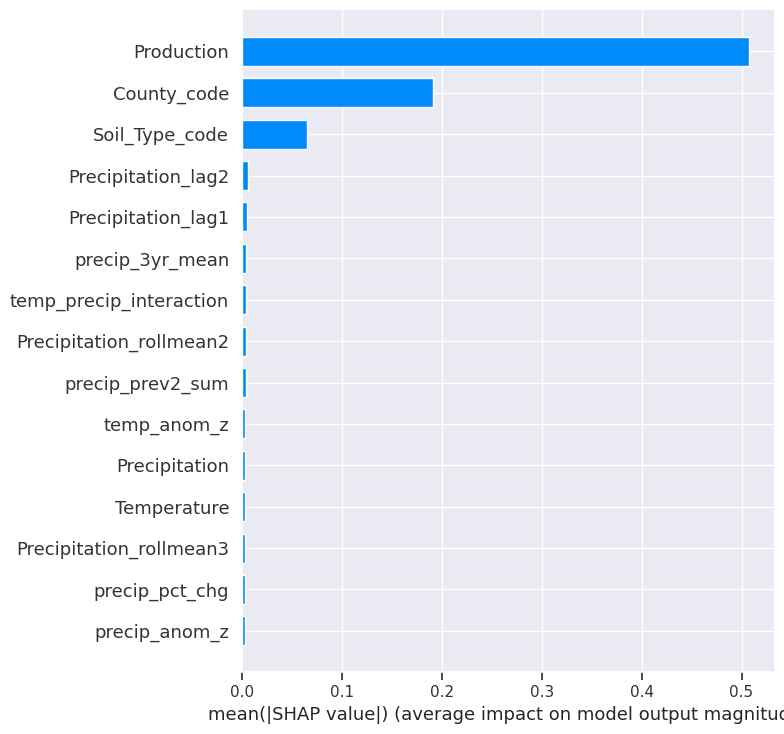


Feature importances (model):


,feature,importance
0,Production,0.681801
14,County_code,0.204166
13,Soil_Type_code,0.076416
3,Precipitation_lag1,0.005296
5,Precipitation_rollmean2,0.003526
4,Precipitation_lag2,0.003460
11,precip_3yr_mean,0.003460
9,temp_anom_z,0.003348
10,precip_prev2_sum,0.003114
12,temp_precip_interaction,0.002919



Top counties by MAE on holdout (stack predictions):


,MAE
County,
Nyeri,0.984782
Elgeyo/Marakwet,0.804788
Nyamira,0.677197
Narok,0.670105
Nairobi,0.655242
Isiolo,0.619212
Kilifi,0.563815
Machakos,0.554740
Kericho,0.539405



Saved models and results to /content/


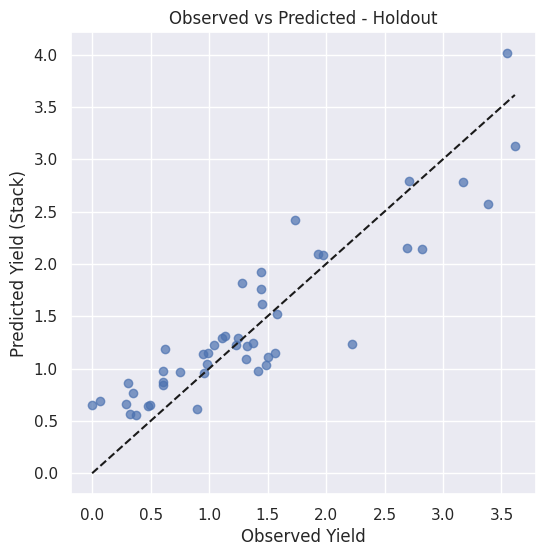

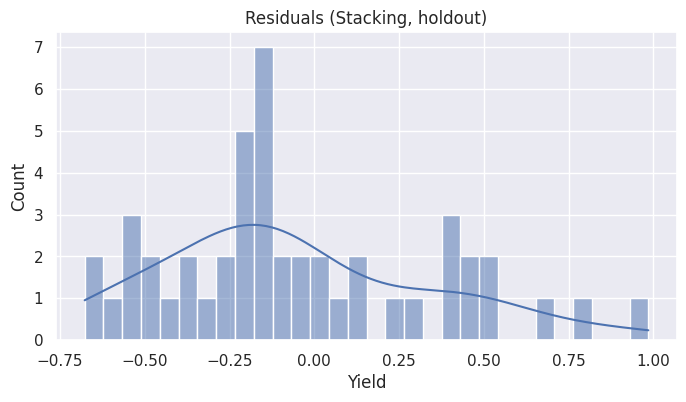


Done. Check results_df for model comparisons, and SHAP plots for interpretability.


In [17]:
# IMPROVED MODELING PIPELINE (feature engineering + modeling + evaluation)
# Paste & run in Colab/Jupyter

# Installs
!pip install -q xgboost lightgbm catboost shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import GroupKFold, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set_theme()
RND = 42
np.random.seed(RND)

# ----------------
# 0. Load data
# ----------------
PATH = "/content/final_dataset.csv"  # change if needed
df = pd.read_csv(PATH)
print("Loaded:", df.shape)
display(df.head())

# ----------------
# 0.5 Basic fixes
# ----------------
# Ensure numeric types
for c in ["Year", "Production", "Yield", "Temperature", "Precipitation", "Area"]:
    # This loop variable 'c' is not used, so it's effectively a no-op if the below condition is not met
    pass # Ensure all numeric columns are correctly typed, or handle them later if they cause issues

# If Production missing but Yield and Area present, reconstruct Production = Yield * Area
if ("Production" in df.columns) and ("Yield" in df.columns) and ("Area" in df.columns):
    mask_reconstruct = df["Production"].isna() & df["Yield"].notna() & df["Area"].notna()
    n_recon = mask_reconstruct.sum()
    if n_recon > 0:
        print(f"Reconstructing Production for {n_recon} rows from Yield * Area")
        df.loc[mask_reconstruct, "Production"] = df.loc[mask_reconstruct, "Yield"] * df.loc[mask_reconstruct, "Area"]

# Create a flag for zero yield (useful for SMAPE and bias checks)
df["yield_zero_flag"] = (df["Yield"] == 0).astype(int)

# Drop rows without Year or County or Yield entirely
df = df.dropna(subset=["Year", "County", "Yield"])
df["Year"] = df["Year"].astype(int)
df["County"] = df["County"].astype(str).str.strip()

# ----------------
# 1. Feature engineering (annual-only data)
# ----------------
# We'll create per-county lag and rolling features (previous-year, 2-yr mean, 3-yr mean), anomalies, pct_change
df = df.sort_values(["County", "Year"]).reset_index(drop=True)

# Lags and rolling aggregations per-county
def add_county_lags_and_rolls(df, col, lags=[1, 2], rolls=[2, 3]):
    for lag in lags:
        df[f"{col}_lag{lag}"] = df.groupby("County")[col].shift(lag)
    for r in rolls:
        df[f"{col}_rollmean{r}"] = df.groupby("County")[col].shift(1).rolling(window=r, min_periods=1).mean().reset_index(level=0, drop=True)
    return df

for col in ["Precipitation", "Temperature", "Yield", "Production"]:
    # Check if column exists before adding lags/rolls
    if col in df.columns:
        df = add_county_lags_and_rolls(df, col)

# Percent change from previous year
if "Precipitation" in df.columns:
    df["precip_pct_chg"] = df.groupby("County")["Precipitation"].pct_change().replace([np.inf, -np.inf], np.nan)

# County-level statistics (mean, std) for anomalies
agg_precip = df.groupby("County")["Precipitation"].agg(["mean", "std"]).rename(columns={"mean": "precip_mean", "std": "precip_std"})
agg_temp = df.groupby("County")["Temperature"].agg(["mean", "std"]).rename(columns={"mean": "temp_mean", "std": "temp_std"})
df = df.merge(agg_precip, left_on="County", right_index=True, how="left").merge(agg_temp, left_on="County", right_index=True, how="left")

# Standardized anomaly features (z-scores relative to county history)
df["precip_anom_z"] = (df["Precipitation"] - df["precip_mean"]) / (df["precip_std"].replace(0, np.nan))
df["temp_anom_z"] = (df["Temperature"] - df["temp_mean"]) / (df["temp_std"].replace(0, np.nan))

# Multi-year aggregates as proxies for growth windows (since we only have annual)
df["precip_prev2_sum"] = df.groupby("County")["Precipitation"].shift(1) + df.groupby("County")["Precipitation"].shift(2)
df["precip_3yr_mean"] = df.groupby("County")["Precipitation"].shift(1).rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)

# Interaction terms
df["temp_precip_interaction"] = df["Temperature"] * df["Precipitation"]

# Replace extreme infinities and big outliers in pct chg
if "precip_pct_chg" in df.columns:
    df["precip_pct_chg"] = df["precip_pct_chg"].clip(-2, 2)  # keep within reasonable bounds

# Flag rows where many features missing
df["missing_feature_count"] = df.isnull().sum(axis=1)

# ----------------
# 2. Encoding categorical features
# ----------------
# Simplify Soil_Type: take first 40 chars to avoid very long strings
if "Soil_Type" in df.columns:
    df["Soil_Type"] = df["Soil_Type"].astype(str).str.strip().str[:40]
    # Label encoding
    df["Soil_Type_code"] = df["Soil_Type"].astype("category").cat.codes

# County code
df["County_code"] = df["County"].astype("category").cat.codes

# ----------------
# 3. Prepare modeling dataset
# ----------------
TARGET = "Yield"
features = ["Production", "Area", "Precipitation", "Temperature",
            "Precipitation_lag1", "Precipitation_lag2", "Precipitation_rollmean2", "Precipitation_rollmean3",
            "precip_pct_chg", "precip_anom_z", "temp_anom_z", "precip_prev2_sum", "precip_3yr_mean",
            "temp_precip_interaction", "Soil_Type_code", "County_code"]

# keep only existing ones
features = [f for f in features if f in df.columns]
model_df = df.dropna(subset=[TARGET])  # must have target
X = model_df[features].copy()
y = model_df[TARGET].copy()

# Simple imputation for features (median)
X = X.fillna(X.median())
print("Model feature shape:", X.shape)
print("Example features:")
display(X.head())

# ----------------
# 4. Train/holdout split (time-aware: holdout = last year)
# ----------------
last_year = model_df["Year"].max()
train_mask = model_df["Year"] < last_year
hold_mask = model_df["Year"] == last_year
X_train = X[train_mask]
y_train = y[train_mask]
groups_train = model_df[train_mask]["County_code"].values
X_hold = X[hold_mask]
y_hold = y[hold_mask]
print("Train rows:", X_train.shape[0], "Holdout rows:", X_hold.shape[0])

# ----------------
# 5. Metrics helpers (use SMAPE to avoid divide by zero)
# ----------------
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom == 0
    denom[mask] = 1e-8
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def regression_metrics(y_true, y_pred):
    return {"R2": r2_score(y_true, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
            "MAE": mean_absolute_error(y_true, y_pred),
            "SMAPE (%)": smape(y_true.to_numpy(), y_pred)}

# ----------------
# 6. Baselines
# ----------------
# Baseline: predict historical county mean yield
county_mean_yield = model_df[model_df["Year"] < last_year].groupby("County")["Yield"].mean().to_dict()
def predict_county_mean(X_df):
    # X_df is subset of model_df; need county mapping
    idx = X_df.index
    counties = model_df.loc[idx, "County"]
    preds = [county_mean_yield.get(c, y_train.mean()) for c in counties]
    return np.array(preds)
baseline_pred_hold = predict_county_mean(X_hold)
print("Baseline (county-mean) metrics:", regression_metrics(y_hold, baseline_pred_hold))

# Global linear regression baseline
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred_hold = lr.predict(X_hold)
print("LinearRegression metrics:", regression_metrics(y_hold, lr_pred_hold))

# ----------------
# 7. Train tree models with light hyperparameter tuning
# ----------------
# Random Forest
rf = RandomForestRegressor(random_state=RND, n_jobs=-1)
rf_param_dist = {"n_estimators": [100, 200, 300],
                 "max_depth": [5, 10, 20, None],
                 "min_samples_leaf": [1, 2, 4]}
rs_rf = RandomizedSearchCV(rf, rf_param_dist, n_iter=6, scoring='neg_root_mean_squared_error',
                           cv=GroupKFold(n_splits=4), random_state=RND, n_jobs=-1, verbose=0)
print("Tuning RandomForest (small search)...")
rs_rf.fit(X_train, y_train, groups=groups_train)
best_rf = rs_rf.best_estimator_
print("RF best:", rs_rf.best_params_)

# XGBoost (light search)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RND, n_jobs=4)
xgb_param_dist = {"n_estimators": [100, 300, 500],
                  "max_depth": [3, 5, 8],
                  "learning_rate": [0.01, 0.05, 0.1],
                  "subsample": [0.6, 0.8, 1.0]}
rs_xgb = RandomizedSearchCV(xgb_model, xgb_param_dist, n_iter=6, scoring='neg_root_mean_squared_error',
                            cv=GroupKFold(n_splits=4), random_state=RND, n_jobs=-1, verbose=0)
print("Tuning XGBoost (small search)...")
rs_xgb.fit(X_train, y_train, groups=groups_train)
best_xgb = rs_xgb.best_estimator_
print("XGB best:", rs_xgb.best_params_)

# LightGBM (quick fit)
best_lgb = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=RND, n_jobs=-1)
best_lgb.fit(X_train, y_train)

# ----------------
# 8. Stacking ensemble
# ----------------
estimators = [("rf", best_rf),
              ("xgb", best_xgb),
              ("lgb", best_lgb)]
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), n_jobs=-1)
stack.fit(X_train, y_train)

# ----------------
# 9. Evaluate on holdout and compare
# ----------------
models_eval = {"Baseline_CountyMean": baseline_pred_hold,
               "LinearRegression": lr_pred_hold,
               "RandomForest": best_rf.predict(X_hold),
               "XGBoost": best_xgb.predict(X_hold),
               "LightGBM": best_lgb.predict(X_hold),
               "Stacking": stack.predict(X_hold)}
results = {}
for name, pred in models_eval.items():
    results[name] = regression_metrics(y_hold, pred)
results_df = pd.DataFrame(results).T
print("\nHoldout performance:")
display(results_df.sort_values("RMSE"))

# ----------------
# 10. Feature Importance & SHAP (explain best tree model)
# ----------------
# choose best performing tree (by RMSE) to explain
best_tree_name = results_df["RMSE"].idxmin()
print("Best on holdout by RMSE:", best_tree_name)
if best_tree_name == "RandomForest":
    expl_model = best_rf
elif best_tree_name == "XGBoost":
    expl_model = best_xgb
elif best_tree_name == "LightGBM":
    expl_model = best_lgb
else:
    expl_model = best_xgb  # fallback
print("Computing SHAP values (take some time)...")
explainer = shap.Explainer(expl_model)
# use a sample of train for speed if needed
X_shap_sample = X_train.sample(min(200, len(X_train)), random_state=RND)
shap_values = explainer(X_shap_sample)

# Summary plot (global)
shap.summary_plot(shap_values, X_shap_sample, plot_type="bar", max_display=20, show=True)

# Show top features DataFrame
if hasattr(expl_model, "feature_importances_"):
    fi = pd.DataFrame({"feature": X_train.columns, "importance": expl_model.feature_importances_}).sort_values("importance", ascending=False)
    print("\nFeature importances (model):")
    display(fi.head(20))

# ----------------
# 11. Bias detection (per-county MAE)
# ----------------
pred_stack = models_eval["Stacking"]
hold_df = model_df[hold_mask].copy()
hold_df["pred_stack"] = pred_stack
group_mae = hold_df.groupby("County").apply(lambda g: mean_absolute_error(g["Yield"], g["pred_stack"]))
group_mae = group_mae.sort_values(ascending=False).rename("MAE")
print("\nTop counties by MAE on holdout (stack predictions):")
display(group_mae.head(10))

# ----------------
# 12. Save final models and results
# ----------------
joblib.dump(best_rf, "/content/best_rf.joblib")
joblib.dump(best_xgb, "/content/best_xgb.joblib")
joblib.dump(stack, "/content/stack_model.joblib")
results_df.to_csv("/content/model_comparison_results.csv", index=True)
print("\nSaved models and results to /content/")

# ----------------
# 13. Quick diagnostics plots
# ----------------
# Observed vs predicted for stacking
plt.figure(figsize=(6, 6))
plt.scatter(y_hold, pred_stack, alpha=0.7)
plt.plot([y_hold.min(), y_hold.max()], [y_hold.min(), y_hold.max()], 'k--')
plt.xlabel("Observed Yield")
plt.ylabel("Predicted Yield (Stack)")
plt.title("Observed vs Predicted - Holdout")
plt.show()

# Residual distribution
residuals = y_hold - pred_stack
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals (Stacking, holdout)")
plt.show()

# Print final message
print("\nDone. Check results_df for model comparisons, and SHAP plots for interpretability.")

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import joblib # Import joblib to load saved models
from sklearn.linear_model import LinearRegression # Import LinearRegression

def evaluate_model(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    # Calculate RMSE by taking the square root of MSE, compatible with older sklearn versions
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # MAPE can break if y_true contains zeros → handle safely
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

    return pd.DataFrame([
        {
            "Model": model_name,
            "R2": r2,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape
        }
    ])

results = []

# --- Load/Retrain models to ensure consistency ---
# Reload best_rf and best_xgb from saved joblib files (from fR8RsTvNVlgH)
best_rf_loaded = joblib.load("/content/best_rf.joblib")
best_xgb_loaded = joblib.load("/content/best_xgb.joblib")

# Re-initialize and fit LinearRegression with X_train from fR8RsTvNVlgH
lr_re_fitted = LinearRegression()
lr_re_fitted.fit(X_train, y_train)

models = [
    ("Linear Regression", lr_re_fitted),
    ("Random Forest", best_rf_loaded),
    ("XGBoost", best_xgb_loaded)
]

# Use X_hold and y_hold for consistent evaluation (from fR8RsTvNVlgH)
for name, model in models:
    y_pred = model.predict(X_hold)
    results.append(evaluate_model(name, y_hold, y_pred))

results_df = pd.concat(results).reset_index(drop=True)
print(results_df)

               Model         R2      RMSE       MAE      MAPE (%)
0  Linear Regression -84.837163  8.412124  8.393682  1.979925e+10
1      Random Forest   0.810832  0.394904  0.317787  1.476224e+09
2            XGBoost   0.801946  0.404073  0.307985  1.215410e+09


Streamlit connection

In [19]:
!pip install streamlit
!pip install pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.0 MB/s eta 0:00:00


Write the App

In [20]:
import joblib

joblib.dump(model, "yield_model.pkl")


['yield_model.pkl']

In [21]:
%%writefile app.py
import streamlit as st
import joblib
import pandas as pd

# Load model
model = joblib.load("yield_model.pkl")

st.title("Maize Yield Prediction App")

# ------------------------------
# USER INPUTS
# ------------------------------
county = st.text_input("County")

precipitation = st.number_input("Precipitation Amount (mm)", min_value=0.0)
temperature = st.number_input("Air Surface Temperature (°C)", min_value=-10.0, max_value=60.0)
soil_texture = st.selectbox(
    "Soil Texture",
    ["Clay", "Silty Clay", "Clay Loam", "Sandy Clay", "Sandy Clay Loam",
     "Silt Loam", "Sandy Loam", "Loam"]
)

# Convert soil texture to numeric (example encoding)
soil_mapping = {
    "Clay": 1,
    "Silty Clay": 2,
    "Clay Loam": 3,
    "Sandy Clay": 4,
    "Sandy Clay Loam": 5,
    "Silt Loam": 6,
    "Sandy Loam": 7,
    "Loam": 8
}

soil_value = soil_mapping[soil_texture]

# Predict button
if st.button("Predict Yield"):
    df = pd.DataFrame({
        "county": [county],
        "precipitation": [precipitation],
        "temperature": [temperature],
        "soil_texture": [soil_value]
    })

    prediction = model.predict(df)[0]
    st.success(f"Predicted Maize Yield: {prediction:.2f} tons/ha")


Writing app.py


In [22]:
%%writefile requirements.txt
streamlit
pandas
numpy
scikit-learn==1.2.2
joblib
xgboost
lightgbm



Writing requirements.txt


In [23]:
!zip -r streamlit_project.zip app.py yield_model.pkl requirements.txt



  adding: app.py (deflated 55%)
  adding: yield_model.pkl (deflated 84%)
  adding: requirements.txt (deflated 3%)
